 Erstellen Sie eine Python-Funktion, welche die Daten aus der Datei einliest (verwenden Sie
 dazu die Numpy-Funktion genfromtxt()), von den Daten die ersten 1000 Werte überspringt
 und aus den nächsten Werten (nehmen Sie eine sinnvolle Anzahl von Messungen) den
 Mittelwert und die Standardabweichung berechnet (der Einschwingvorgang wird dadurch
 ignoriert). Vergleichen Sie die Ergebnisse mit den Werten aus Ihrer gemessenen Tabelle.
 Stellen Sie die gefundene Übertragungsfunktion bzw. Kennlinie im Notebook graphisch mit
 Python bzw. Matplotlib dar.

In [35]:
import os

import numpy as np
from matplotlib import pyplot as plt

# get current working directory
path = os.getenv('DATA_PATH')
if not path:
    raise ValueError("DATA_PATH environment variable is not set")

converters = {i: lambda s: float(s.decode().replace(',', '.')) for i in range(2)}

mean_list = []  # list to store the mean of the data from each file
std_list = []  # list to store the standard deviation of the data from each file
for i in range(10, 71, 3):
    # Replace the German decimal comma with a dot and remove separators
    csv_data = np.genfromtxt(f"{path}\\V1_{i}.csv", delimiter=";", skip_header=1000, skip_footer=1, dtype=float,
                             converters=converters)

    # Write only voltage in array
    voltage_data = csv_data[:, 1]

    # get the mean of the data
    mean = np.mean(voltage_data, axis=0)
    print(f"{i} {mean}")
    # get the standard deviation of the data
    std = np.std(voltage_data, axis=0, ddof=1)
    # Standardabweichung 
    # print(f"{i} {std}")
    mean_list.append(mean)
    std_list.append(std)

10 1.348606293778899
13 1.188338332240437
16 1.0593454600861705
19 0.9422708880128206
22 0.8682159075662046
25 0.8056663341288358
28 0.7491368855590583
31 0.6904930504592267
34 0.6511101496920977
37 0.6298625915531737
40 0.5952422504529212
43 0.5538551747078603
46 0.5353349117349725
49 0.516292314482976
52 0.4767991058984868
55 0.4582667302280369
58 0.4396033265079865
61 0.43869589409205534
64 0.41796839935477076
67 0.41720390158575016
70 0.3973853027448507


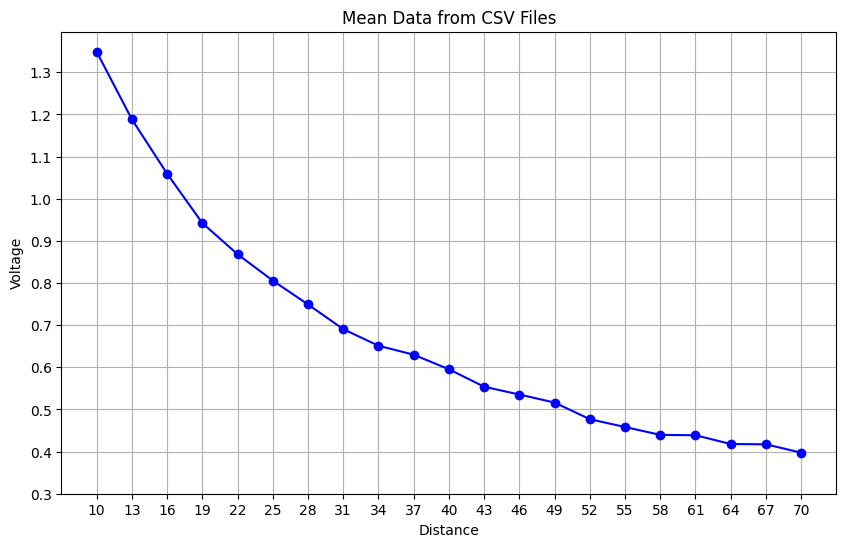

In [36]:
# plot the mean data with matplotlib
# Create a plot
distance = np.array(range(10, 71, 3))

plt.figure(figsize=(10, 6))
plt.plot(distance, mean_list, marker='o', linestyle='-', color='b')
plt.title('Mean Data from CSV Files')
plt.xlabel('Distance')
plt.ylabel('Voltage')
plt.xticks(distance)  # Set x-ticks to match column indices
plt.yticks(np.arange(0.3, 1.4, 0.1))  # Set y-ticks
plt.grid(True)
plt.show()

 2. Modellierung der Kennlinie durch lineare Regression

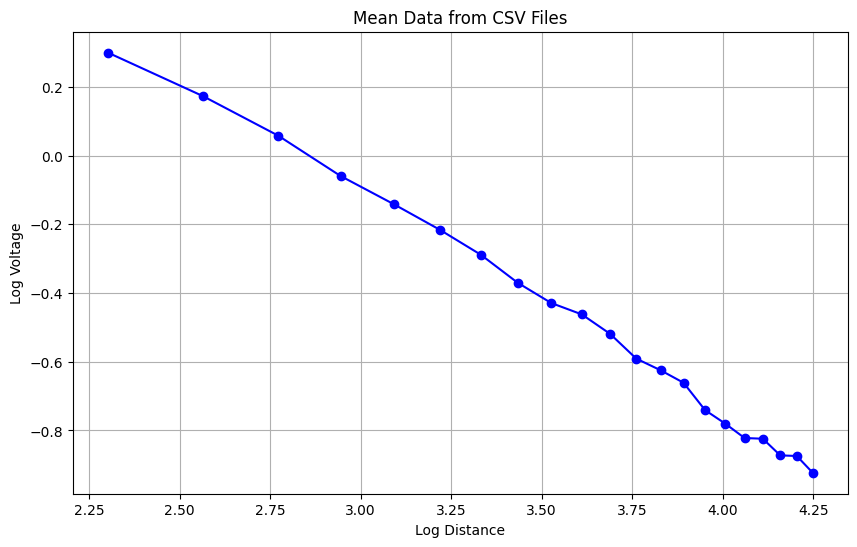

In [37]:
distance = np.array(range(10, 71, 3))

log_distance = np.log(distance)
log_mean = np.log(mean_list)
# plot the log data with matplotlib

plt.figure(figsize=(10, 6))
plt.plot(log_distance, log_mean, marker='o', linestyle='-', color='b')
plt.title('Mean Data from CSV Files')
plt.xlabel('Log Distance')
plt.ylabel('Log Voltage')
plt.grid(True)
plt.show()
    

 3. Berechnen Sie mithilfe der linearen Regression, wie in der Vorlesung behandelt, die
 Ausgleichsgerade in Python. Eliminieren Sie ggf. Werte für sehr große Entfernungen,
 für die der lineare Zusammenhang nicht mehr gilt.

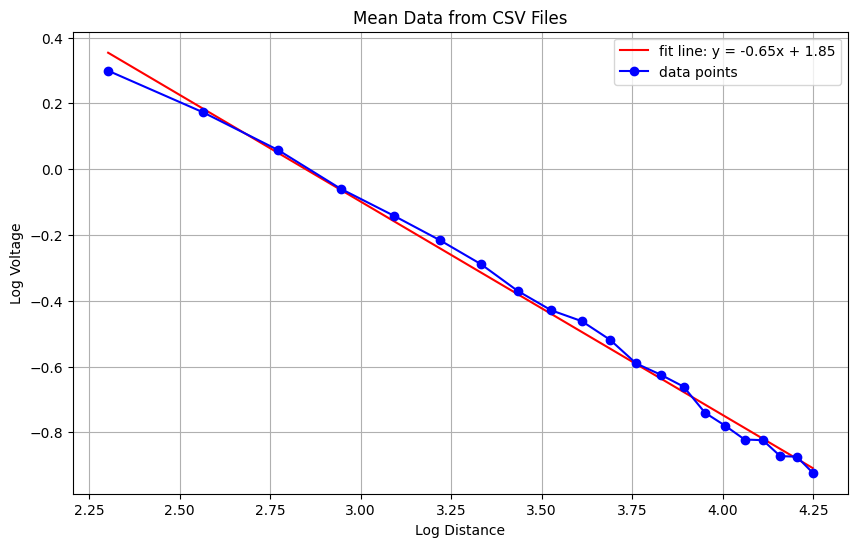

In [46]:
numerator = 0
denominator = 0
for i in range(len(log_distance)):
    numerator += (log_distance[i] - np.mean(log_distance)) * (log_mean[i] - np.mean(log_mean))
    denominator += (log_distance[i] - np.mean(log_distance)) ** 2
    
a = numerator / denominator
b = np.mean(log_mean) - a * np.mean(log_distance)

regression = a * log_distance + b

# plot the log data with matplotlib
# plot the mean data with matplotlib
# Create a plot
distance = np.array(range(10, 71, 3))

plt.figure(figsize=(10, 6))
# Calculate the corresponding y-values for the line y = a * x + b
# Plot the regression line
plt.plot(log_distance, regression, color='r', label=f'fit line: y = {a:.2f}x + {b:.2f}')

# plot the log data with matplotlib

plt.plot(log_distance, log_mean, marker='o', linestyle='-', color='b', label='data points')
plt.title('Mean Data from CSV Files')
plt.xlabel('Log Distance')
plt.ylabel('Log Voltage')
plt.grid(True)
plt.legend( )
plt.show()

 Die Rückrechnung auf den ursprünglichen Zusammenhang geschieht über die Umkehrung
 der doppelten Logarithmierung: y=exp(a·lnx+b)
 wobei x hier die Spannungsmessung und y die daraus resultierende Abstandsmessung darstellt.
 Damit haben wir die nichtlineare Kennlinie des Sensors gefunden.

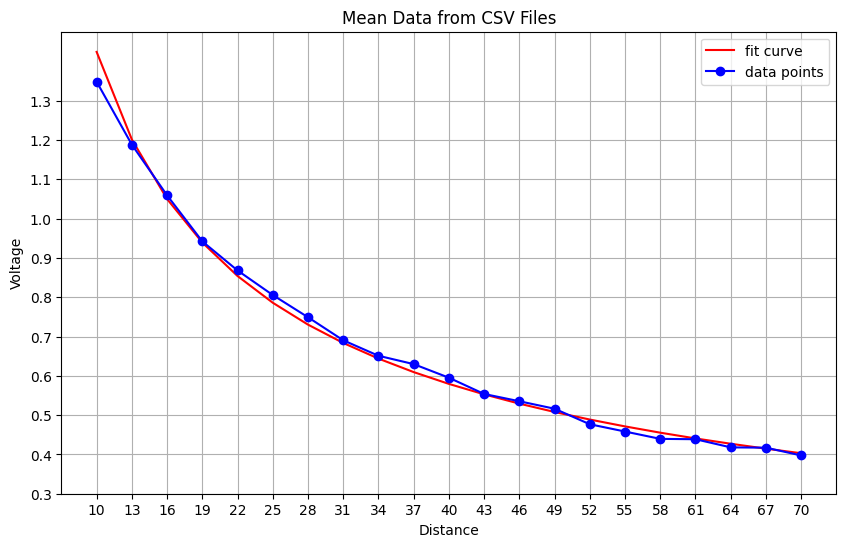

In [47]:
# Calculate the original relation
regression_curve = np.exp(a * log_distance + b)

# plot the mean data with matplotlib
plt.figure(figsize=(10, 6))

plt.plot(distance, regression_curve, color='r', label='fit curve')

# original plot
plt.plot(distance, mean_list, marker='o', linestyle='-', color='b', label='data points')
plt.title('Mean Data from CSV Files')
plt.xlabel('Distance[cm]')
plt.ylabel('Voltage[V]')
plt.xticks(distance)  # Set x-ticks to match column indices
plt.yticks(np.arange(0.3, 1.4, 0.1))  # Set y-ticks
plt.grid(True)
plt.legend()
plt.show()

 3. Flächenmessung mit Fehlerrechnung
 a. Ermittlung des Messfehlers des Abstandsmessers: Die Kombination aus Sharp-Sensor,
 Oszilloskop und der gefundenen Kennlinie stellt eine Messeinrichtung für den Abstand
 eines Objektes dar. Durch die Kennlinie wird der Abstand nicht direkt ermittelt, sondern
 indirekt über eine Spannungsmessung. Zur Ermittlung des Messfehlers müssen wir also die
 Fehlerfortpflanzung durch die Kennlinie ebxa berechnen.
 Vorgehensweise:
 1. Stellen Sie das Zielobjekt im Abstand eines DIN-A4-Blattes (lange Seite) vom Sensor auf
 und führen Sie eine einzige Messung aus und speichern Sie das Resultat als csv-Datei.
 2. Schätzen Sie den Messfehler nach der Methode aus der Vorlesung. Vergessen Sie
 dabei nicht eine eventuelle Korrektur aufgrund der Anzahl von Messungen. Geben
 Sie das Ergebnis Ihrer Spannungsmessung in der korrekten Form an. Wie groß ist der
 Vertrauensbereich für eine Sicherheit von 68%, wie groß für eine Sicherheit von 95%?
 3. Geben Sie nun das Ergebnis Ihrer Abstandsmessung in cm in korrekter Form an.
 Benutzen sie dazu die Fehlerfortpflanzung.
 b. Flächenmessung: Zur Ermittlung der Fläche eines DIN A4-Blattes messen Sie nun nach
 derselben Methode wie in Aufgabe 3a die Breite des Blattes aus. Berechnen Sie daraus
 Ihre Schätzung für die Fläche des Blattes und geben Sie Ihr Messergebnis korrekt mit Ihrer
 Schätzung des Messfehlers an. Benutzen Sie dazu das Gaußsche Fehlerfortpflanzungsgesetz
 aus der Vorlesung.
